# <font color=blue> **Food Image Classifier** </font>

This notebook describes the implementation of a food classifier using the fast.ai library for neural networks. The classifier should distinguish between images of 5 different food categories. The development proceeds in 5 steps and each step is thorougly explained and accompanied with the corresponding code.

The goal of the classifier is to correctly distinguish the following food categories:

- risotto
- steak
- mac n' cheese
- burger
- sushi

This notebook is divided in  the following 5 sections:

1. Creating an imageset
2. View the data
3. Train the model
4. Results interpretation and error analysis
5. Cleaning up the dataset

The fast.ai library will be used, as it provides a high level encapsulation of otherwise tedious procedures. 

In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

from fastai.vision import *

## 1. Creating a dataset 

In order to create an image classifier, an image dataset is required. So the first that should be done is finding and labeling the images.

For each class, we have gone to google images, scrolled down to the bottom and once the end was reached, the following lines of code should be typed in the browser console ( <kbd>Ctrl</kbd> + <kbd>Shift</kbd> + <kbd>j</kbd> ):

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

This will open a window that asks the user where to save a .csv file containing the urls of all the images shown in the page. 

To do that, we will be scraping images from google using a small javascript script. An alternative would be to  use the [google_images_download](https://github.com/hardikvasa/google-images-download) package.

Once the above process has been completed,  data directory needs to be created in order to download the images in the proper place. Creating and maintaining a certain folder structure is essential to properly use the fastai library objects later on. The folder <font color=green>'data'</font> contains the .csv files with the image URLs for each class. We will now create a <font color=green>'train'</font> folder that should include all the training data. Each class category should have its own separate subfolder so that the ImageDataBunch object we will use later can label images correctly.

In [2]:
classes = ['risotto','steak','burger','macncheese','sushi']

In [3]:
path = Path('data')

In [4]:
%%capture
for c in classes:
    folder = 'train/' + c
    file = f"urls_{c}.csv"
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    if not os.listdir(dest):
      download_images(path/file, dest, max_pics=500)

Running the above cell downloads all training data and creates the required folder structure mentioned above. Next we shall verify that all downloaded images can be opened. If any image is corrupt and cannot be opened, it will be deleted.

In [5]:
for c in classes:
    print(c)
    verify_images(path/'train'/c, delete=True, max_size=500)

risotto


steak


burger


macncheese


sushi


After cleaning, 2000 images are contained in the imageset.

A test dataset is also required to test the performance of the model. Therefore, a <font color=green>'test'</font> folder is created under <font color=green>'data'</font>. The whole imageset will be split in a  60%/20%/20% ratio (train/dev/test set). For each class, 20% of the images are chosen randomly and transfered to the corresponding test subfolder. The devset does not require a separate directory, as its percentage can be passed on as a parameter to the ImageDataBunch object. 

In terms of image count, the 2000 images are split at a 1600/200/200 ratio.


In [6]:
for folder in classes:
    dest = path/'test'/folder
    dest.mkdir(parents=True, exist_ok=True)

    files = os.listdir(path/"train"/folder)
    
    if not os.listdir(path/'test'/folder):
    
        test_size = int(len(files)/5)
        indices = random.sample( range(len(files)),test_size)
        chosen_files = [files[i] for i in indices ]
        chosen_files_paths = [path/'train'/folder/file for file in chosen_files]
        
        for curr_path in chosen_files_paths:
            shutil.move(str(curr_path),str(dest))

The structure of the <font color=green>'data'</font> folder now looks as follows. 

.data \
&emsp;       |--train \
&emsp;&emsp;    |-- risotto \
&emsp;&emsp;    |-- steak \
&emsp;&emsp;    |-- burger\
&emsp;&emsp;    |-- macncheese \
&emsp;&emsp;    |-- sushi \
&emsp;       |--test \
&emsp;&emsp;    |-- risotto \
&emsp;&emsp;    |-- steak \
&emsp;&emsp;    |-- burger \
&emsp;&emsp;    |-- macncheese \
&emsp;&emsp;    |-- sushi 

We are now in a position to create the ImageDataBunch object that will contain the imageset. To do that, we specify the following parameters:

<font color= red>path</font> : path to the <font color=green>'data'</font> folder. \
<font color= red>train</font>: folder containing the training set \
<font color= red>test</font> : folder containing the test set \
<font color= red>valid_pct</font>: percentage of training set to be used as devset. 0.25 is chosen to have the same number of images in the dev and test sets (200 images). \ 
<font color= red>ds_tfms</font>: apply transformations to input images to ensure they are of the same size. get_transforms() creates a list of flip, rotate, zoom, warp, lighting transforms. The output of the transform is a square image. \
<font color= red>size</font>: dimensions of the image that will be resized \
<font color= red>bs</font>: batch size \
<font color= red>num_workers</font>: number of CPU's to use to create the imageset

With the .normalize(imagenet_stats) call, the images of the dataset are normalized using stats from the imagenet dataset.

In [33]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path,
                                  train = "train",
                                  test  = "test",
                                  valid_pct = 0.25,
                                  ds_tfms = get_transforms(),
                                  size = 256,
                                  bs = 64,
                                  num_workers = 4).normalize(imagenet_stats)

We can now take a look at some random images from the dataset, along with their corresponding labels. Since the dataset was created by web scraping and has not been cleaned up yet, it is possible that some of the images do not depict the desired label properly. Cleaning the dataset is a process that will be carried out later in the process.

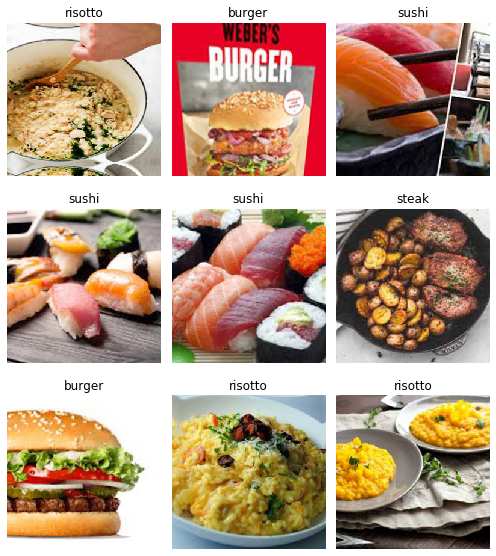

In [23]:
data.show_batch(rows=3, figsize=(7,8))

## 3. Train model

Collecting and preprocessing the data has been carried out. Therefore, we can now train an image classifier. This is achieved by creating a convolutional neural network object through cnn_learner. The parameters that need to be specified are: 

<font color=red> data </font>: ImageDataBunch object containing the imageset \
<font color=red> base_arch</font>: specify the architecture of the network. Can be either a predefined architecture or a custom model. In this classifier, the Resnet50 architecture has been chosen. \
<font color=red>metrics</font>: specify the metrics that the model shall be evaluated on. Accuracy has been chosen for this classifier. 

In [39]:
learn = cnn_learner(data,
                         base_arch = models.resnet50,
                         metrics = [accuracy]
                        )

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

We are now ready to start training our model. For training, the fit_one_cycle function will be used. It trains the model according to the 1-cycle policy, where the learning rate is not held constant, but variates while iterating over the different batches. The advantage of cycling the learning rate is that, if the model is stuck at a saddle point or a local minimum, getting out of that point is achieved at a much faster pace. 

A cycle is defined as the number of epochs  over which the learning rate goes from a specified lower bound to the specified upper bound and then back to the lower bound. An epoch is defined as one iteration over the whole dataset. Therefore, we first fit the model over 1 cycle of 2 epochs and save the resulting weight coefficients.

In [40]:
torch.device('cuda')
learn.fit_one_cycle(2)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.938036,0.396013,0.890000,00:08
1,0.617208,0.326518,0.890000,00:08


A very nice feature of learner objects of the fast.ai library is the lr_find() and recorder.plot() functions. It allows the user to plot the loss function over various learning rates. Looking at the plot enables the user to choose an appropriate interval over which the cyclical learning rate will variate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


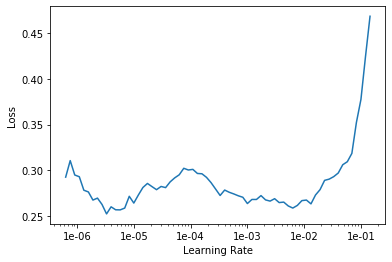

In [41]:
learn.lr_find()
learn.recorder.plot()

Since the training procedure is working properly (error rate is decreasing), we would like to train our model a bit more to improve performance. To achieve this, the weight have to be "unfrozen", as the fit_one_cycle method freezes them, i.e. prevents them from being modified. 

In the current model, we see that the loss remains low for learning rates between $10^{-6}$ and $5*10^{-5}$. Now that we have that knowledge, we can train the model further using the fit_one_cycle function again and save the results. Then, we repeat the same process, untill we reach a satisfactory result or until the validation and training error increase.

In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice( 5e-5))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.280026,0.295630,0.915000,00:10
1,0.267630,0.279070,0.920000,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


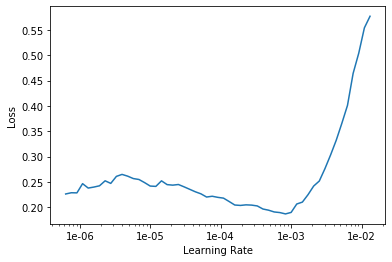

In [43]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3e-3))
learn.save('stage-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.454093,1.107493,0.820000,00:10
1,0.378931,0.423397,0.897500,00:10


## 4. Interpretation & Error Analysis



In [51]:
%%capture
learn.load('stage-2')

After the model has been trained, we would like to perform error analysis and interpret the results to see in which areas the model performs well and in in which it underperforms. A convenient way to do that is to create an instance of the ClassificationInterpretation class that required a learner object as input and can then produce a confusion matrix or a visualization of the examples that produce the highest loss to the model.

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

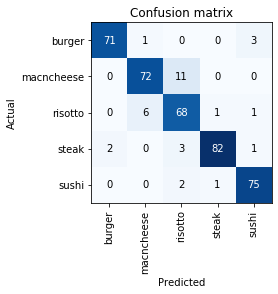

In [53]:
interp.plot_confusion_matrix()

The confusion matrix  plots a matrix of the actual labels and the predicted ones. Since our model's training run correctly, the elements on the diagonal should contain the highest numbers, whereas the other areas of the matrix should be as sparse as possible. 

Looking at the matrix can help us gain insights as to where the missclassifications occur. In our model, the algorithm has a hard time distinguishing between risotto and mac n' cheese images. This was expected, since these 2 foods can, in many cases, look alike.

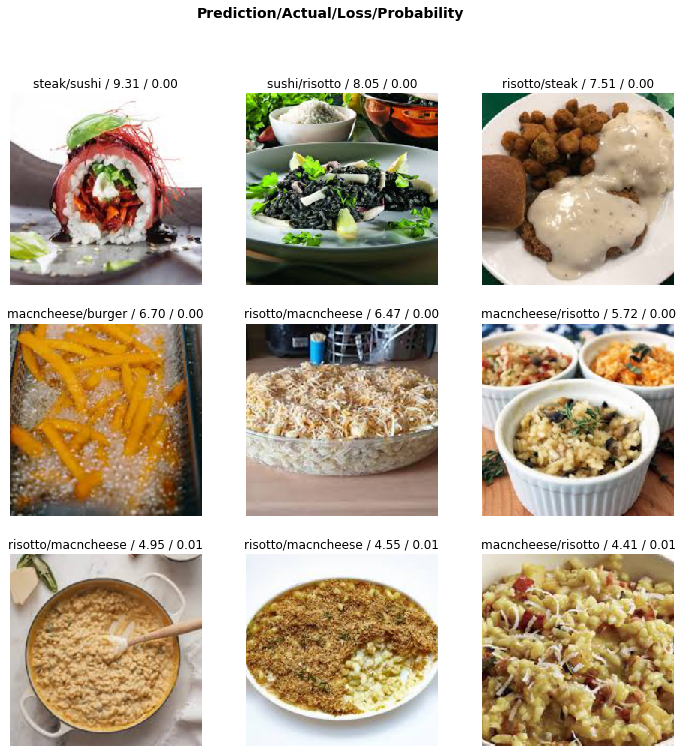

In [54]:
interp.plot_top_losses(9,figsize=(12, 12))

## 5. Cleaning Up

Since the imageset was created from web scraping and was not cleaned up before training, some images may not be properly depicting their label. The fastai library provides a very convenient tool to do so. 

In [55]:
from fastai.widgets import *

The first step is to create a list of the paths of all the images and load the weights that we computed before. Using that model, we can collect the indices of the examples that produce the top losses.

In [56]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(),
                    size=224)
                   .databunch()
     )

In [57]:
learn_cln = cnn_learner(db,
                        models.resnet50,
                        metrics = [accuracy]
                       )

learn_cln.load('stage-2');

In [58]:
ds_loss, idxs_loss = DatasetFormatter().from_toplosses(learn_cln)

Now we can call the ImageCleaner objectand pass to it the indices of the top losses and the path to the imageset. This will produce an interactive window that show the images that produce the top losses along with their label. The user can then manually choose which images should be deleted. When all the images are processed, a .csv file is produced that contains the paths to the images we would like to keep. Using that file we are now in position to create a new, clean imageset.

In [59]:
ImageCleaner(ds_loss, idxs_loss, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

We can perform another cleaning action to remove duplicate images. Following the same procedure as above and  calling  the from_similars() function instead of from_toplosses() will open a panel where the user can delete any duplicate images from the imageset. The result of the function is again a .csv file with the cleaned dataset.

In [60]:
ds_sim, idxs_sim = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [61]:
ImageCleaner(ds_sim, idxs_sim, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## 6.  Exporting the model

After a model has been trained on a clean dataset, it is ready to be exported to be used in an application. The following command exports the model into a .pkl file. This file can be then loaded into a learner using the load_learner(path) function, where path is the path to the .pkl file.

For a new image, calling the learner.predict() function will assign a label to an image.

In [62]:
learn.export()